In [1]:
!pip install ucimlrepo

In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

In [3]:
import pandas as pd
import numpy as np

names = heart_disease.variables['name'][0:13]
columns_names = [name for name in names]
heart_disease_df = pd.DataFrame(heart_disease.data.features, columns=columns_names)
heart_disease_df['num'] = heart_disease.data.targets

What the fuck

In [23]:
# Inspect the unique values in the target column
unique_values = heart_disease_df['num'].unique()
print("Unique values in the target column:", unique_values)

# Check the number of unique values
num_unique_values = len(unique_values)
print("Number of unique values:", num_unique_values)

# If there are more than two unique values, inspect their distribution
if num_unique_values > 2:
    value_counts = heart_disease_df['num'].value_counts()
    print("Value counts:\n", value_counts)


Unique values in the target column: [0 2 1 3 4]
Number of unique values: 5
Value counts:
 0    164
1     55
2     36
3     35
4     13
Name: num, dtype: int64


In [24]:
heart_disease_df['num']

0      0
1      2
2      1
3      0
4      0
      ..
298    1
299    2
300    3
301    1
302    0
Name: num, Length: 303, dtype: int64

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


In [31]:
class DataPreprocessing:
    def __init__(self, dataframe, target_column):
        self.data = dataframe
        self.target_column = target_column
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = None

    def preprocess_data(self):
        self.data = self.data.dropna()
        self.data[self.target_column] = self.data[self.target_column].apply(lambda x: 1 if x > 0 else 0)
        self.X = self.data.drop(columns=[self.target_column])
        self.y = self.data[self.target_column]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.20, random_state=42
        )
        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)


class ModelTraining:
    def __init__(self, model, X_train, y_train, X_test, y_test):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.predictions = None

    def train_model(self):
        self.model.fit(self.X_train, self.y_train)
        self.predictions = self.model.predict(self.X_test)
        
    def evaluate_model(self):
        accuracy = accuracy_score(self.y_test, self.predictions)
        precision = precision_score(self.y_test, self.predictions)
        recall = recall_score(self.y_test, self.predictions)
        f1 = f1_score(self.y_test, self.predictions)
        cm = confusion_matrix(self.y_test, self.predictions)
        return accuracy, precision, recall, f1, cm

class HyperParameterTuning:
    def __init__(self, model, param_grid, X_train, y_train):
        self.model = model
        self.param_grid = param_grid
        self.X_train = X_train
        self.y_train = y_train
        self.best_model = None

    def perform_randomized_search(self):
        print("Randomized SEARCHING")
        rand_search = RandomizedSearchCV(
            self.model, param_distributions=self.param_grid, 
            n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1
        )
        rand_search.fit(self.X_train, self.y_train)
        self.best_model = rand_search.best_estimator_

    def perform_grid_search(self):
        print("GRID SEARCHING")
        grid_search = GridSearchCV(
            self.model, param_grid=self.param_grid, 
            cv=5, verbose=2, n_jobs=-1
        )
        grid_search.fit(self.X_train, self.y_train)
        self.best_model = grid_search.best_estimator_

    def get_best_model(self):
        return self.best_model


In [40]:
def main():
    # Data Preprocessing
    names = heart_disease.variables['name'][0:13]
    column_names = [name for name in names]
    heart_disease_df = pd.DataFrame(heart_disease.data.features, columns=column_names)
    heart_disease_df['num'] = heart_disease.data.targets
    target_column = 'num'
    data_preprocessor = DataPreprocessing(heart_disease_df, target_column)
    data_preprocessor.preprocess_data() 

    models = [LogisticRegression(), RandomForestClassifier(), XGBClassifier(use_label_encoder=False, eval_metric='logloss')]
    model_names = ['Logistic Regression', 'Random Forest', 'XGBoost Classifier']

    # XGBoost hyperparameters
    param_grid_xgb = {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
        'max_depth': [3, 4, 5, 6, 7, 8, 10],
        'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
        'gamma': [0, 0.25, 0.5, 1.0]
    }

    xgb_tuning = HyperParameterTuning(
        XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric='logloss'),
        param_grid_xgb, 
        data_preprocessor.X_train, 
        data_preprocessor.y_train
    )

    # Perform Randomized Search and Grid Search
    xgb_tuning.perform_randomized_search()
    best_xgb_model_random = xgb_tuning.get_best_model()

    # xgb_tuning.perform_grid_search()
    # best_xgb_model_grid = xgb_tuning.get_best_model()


    param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

    rf_tuning = HyperParameterTuning(
        RandomForestClassifier(random_state=42),
        param_grid_rf, 
        data_preprocessor.X_train, 
        data_preprocessor.y_train
    )
    
    # Perform Randomized Search and Grid Search
    rf_tuning.perform_randomized_search()
    best_rf_model_random = rf_tuning.get_best_model()
    
    # rf_tuning.perform_grid_search()
    # best_rf_model_grid = rf_tuning.get_best_model()
    
    models.extend([best_xgb_model_random, best_rf_model_random])

# Updating the model names list
    model_names.extend([
        'XGBoost Classifier - Best Randomized',
        'Random Forest - Best Randomized',
        # 'XGBoost Classifier - Best Grid',
        # 'Random Forest - Best Grid'
    ])
    # Iterate to train each model
    for model, model_name in zip(models, model_names):
        model_trainer = ModelTraining(model, data_preprocessor.X_train_scaled, data_preprocessor.y_train, data_preprocessor.X_test_scaled, data_preprocessor.y_test)
        model_trainer.train_model()
        accuracy, precision, recall, f1, cm = model_trainer.evaluate_model()
        print(f"{model_name}:\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")
        
        # Visualize Confusion Matrix
        sns.heatmap(cm, annot=True, fmt='g')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.show()

C:\Users\joonb\AppData\Local\Temp\ipykernel_2500\576207673.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.target_column] = self.data[self.target_column].apply(lambda x: 1 if x > 0 else 0)


Randomized SEARCHING
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Randomized SEARCHING
Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\joonb\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
245 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
142 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joonb\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joonb\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\joonb\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py"

Logistic Regression:
Accuracy: 0.8666666666666667
Precision: 0.8333333333333334
Recall: 0.8333333333333334
F1 Score: 0.8333333333333334


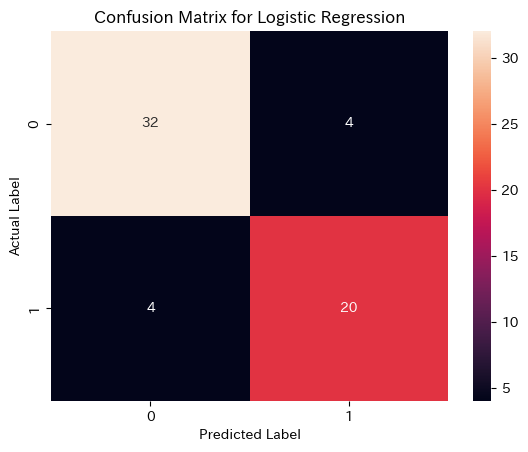

Random Forest:
Accuracy: 0.8666666666666667
Precision: 0.8333333333333334
Recall: 0.8333333333333334
F1 Score: 0.8333333333333334


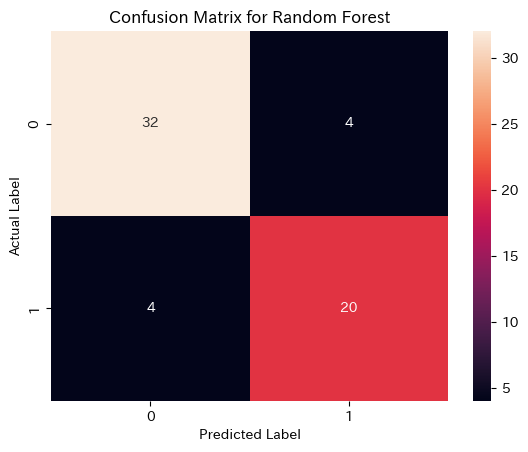

XGBoost Classifier:
Accuracy: 0.8333333333333334
Precision: 0.75
Recall: 0.875
F1 Score: 0.8076923076923077


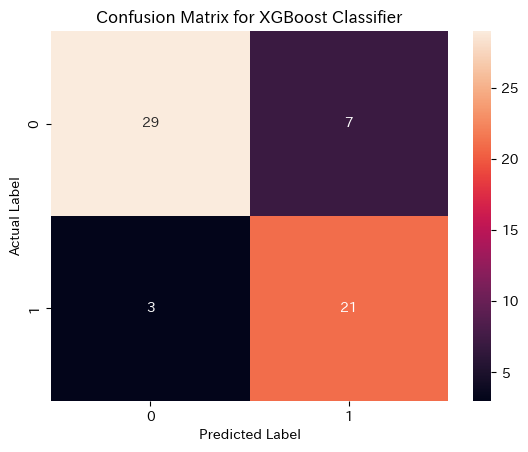

XGBoost Classifier - Best Randomized:
Accuracy: 0.8666666666666667
Precision: 0.8333333333333334
Recall: 0.8333333333333334
F1 Score: 0.8333333333333334


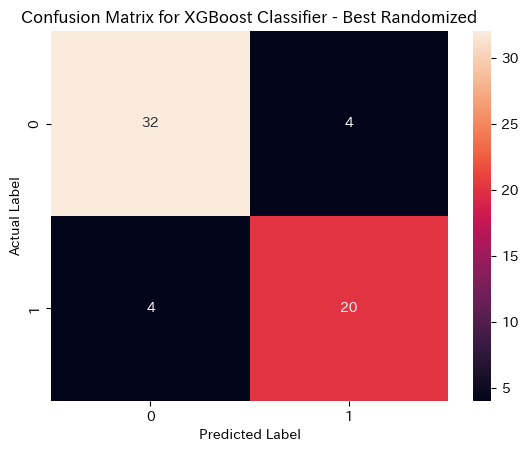

Random Forest - Best Randomized:
Accuracy: 0.8666666666666667
Precision: 0.8076923076923077
Recall: 0.875
F1 Score: 0.8400000000000001


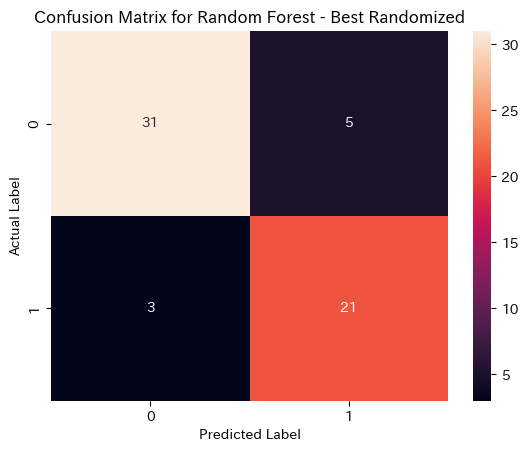

In [41]:
if __name__ == "__main__":
    main()

# NOT WORTH THE TIME FOR GRID SEARCH

# BEST MODEL IS PROBABLY RANDOM FOREST